In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import itertools
from ipywidgets import interact, interactive
import re
import hashlib
from scipy import stats
sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

In [3]:
copd = pd.read_csv("chronic_obstructive_pulmonary_disease.csv")
copd.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2014,2014,AK,Alaska,NVSS,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,NaN,NaN,Number,...,2,COPD,COPD1_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
1,2020,2020,AL,Alabama,NVSS,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,NaN,NaN,Number,...,1,COPD,COPD1_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2012,2012,AL,Alabama,NVSS,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,NaN,NaN,Number,...,1,COPD,COPD1_1,NMBR,RACE,BLK,NaN,NaN,NaN,NaN
3,2015,2015,AL,Alabama,NVSS,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,NaN,NaN,Number,...,1,COPD,COPD1_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
4,2017,2017,AL,Alabama,NVSS,Chronic Obstructive Pulmonary Disease,Mortality with chronic obstructive pulmonary d...,NaN,NaN,Number,...,1,COPD,COPD1_1,NMBR,RACE,BLK,NaN,NaN,NaN,NaN


In [8]:
prompt = 'Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years'

In [70]:
ca = copd[copd['LocationAbbr'] ==  'CA']
ca = ca[ca['Question'] == prompt]
ca = ca[ca['DataValueUnit'] == 'cases per 100,000']
ca = ca[ca['DataValueType'] == 'Crude Rate']
ca = ca[ca['StratificationCategoryID1'] == 'OVERALL']
ca = ca[['YearStart', 'LocationAbbr', 'Question', 'DataValueUnit', 'DataValue']]
ca = ca.sort_values('YearStart')
ca['DataValue_Round'] = round(ca['DataValue'])
ca['Per 100,000'] = 100000
ca

,YearStart,LocationAbbr,Question,DataValueUnit,DataValue,DataValue_Round,"Per 100,000"
1273,2010,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",91.8,92.0,100000
2448,2011,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",92.2,92.0,100000
724,2012,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",87.9,88.0,100000
2940,2013,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",90.5,90.0,100000
596,2014,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",82.8,83.0,100000
2085,2015,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",86.6,87.0,100000
4141,2016,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",86.3,86.0,100000
3186,2017,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",86.3,86.0,100000
525,2018,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",84.4,84.0,100000
2142,2019,CA,Mortality with chronic obstructive pulmonary d...,"cases per 100,000",80.6,81.0,100000


Text(0.5, 1.0, 'California Crude Rate of COPD Mortality Among Adults Aged >= 45 Years')

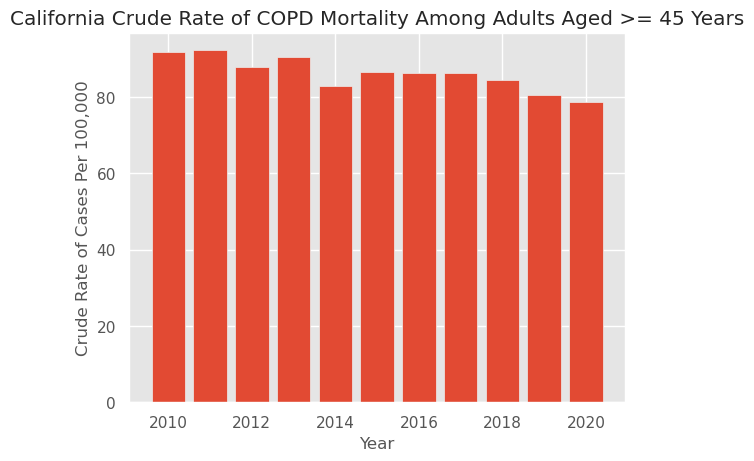

In [53]:
x = ca['YearStart']
y = ca['DataValue']
plt.bar(x,y,align='center') # A bar chart
plt.xlabel('Year')
plt.ylabel('Crude Rate of Cases Per 100,000')
plt.title('California Crude Rate of COPD Mortality Among Adults Aged >= 45 Years')

In [54]:
import pymc as pm
import arviz as az

In [88]:
ca.iloc[1,0]

2011

In [75]:
num_years = len(ca['YearStart'])
with pm.Model() as model:
    a = pm.HalfCauchy('a', beta=1)
    b = pm.HalfCauchy('b', beta=1)
    theta = pm.Beta('theta', alpha=a, beta=b, shape=num_years) 
    y = pm.Binomial('y',p=theta, n=ca['Per 100,000'], observed=ca['DataValue_Round'])

    trace_eb = pm.sample(2000, chains = 1, tune=200, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a, b, theta]


Sampling 1 chain for 200 tune and 2_000 draw iterations (200 + 2_000 draws total) took 62 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


KeyError: 0

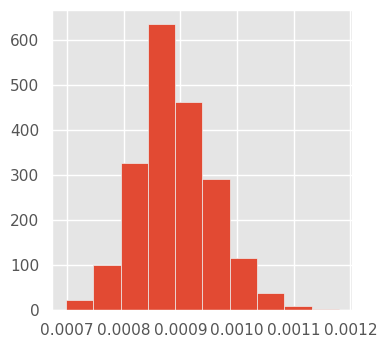

In [77]:
for i in np.arange(num_years):
    fig=plt.figure(figsize=(3,3))
    his=fig.add_axes([0,0,1,1])
    year_i_sample = [row[i] for row in trace_eb.posterior['theta'][0]]
    plt.hist(year_i_sample)
    plt.title("Samples of Mortality of COPD in California in Year " + ca.iloc[i,0])
    region_array = np.array([row[i] for row in trace_eb.posterior['theta'][0]])
    az.plot_posterior(region_array, figsize = (4,4), hdi_prob = 0.95)
    plt.show()